## **演示0802：正则化处理**

### **案例1：使用高阶拟合非线性可分的数据**
本案例对【data_for_regulizing.csv】中的数据进行二分类。  
每个样本包含两个特征和一个分类标记

>**步骤1：数据可视化**  
下面的代码，将第一个特征作为横坐标，第二个特征作为纵坐标；将标记为1类的点用红色+号表示，标记为0类的点用黑色圆点表示

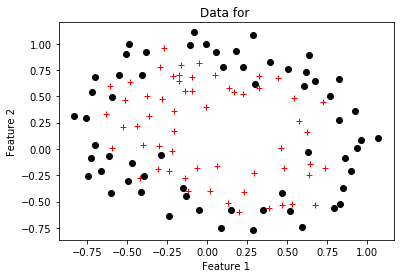

In [1]:
''' 查看样本数据 '''

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

trainData = np.loadtxt(open('data_for_regulizing.csv', 'r'), delimiter=",", skiprows=0)
x1 = trainData[:,0]         # 第一个变量
x2 = trainData[:,1]         # 第二个变量
y = trainData[:,2]          # 因变量

def initPlot():
    plt.figure()
    plt.title('Data for ')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    return plt

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]	
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')
plt.show()

从上图可见，无法使用简单的分界线来区分两类数据。也就是说，这些数据是**线性不可分**的，必须采用高阶曲线才可能区分。  
因此采用$h_(\theta)=g(\theta_0+\theta_1 x_1+ \theta_2 x_2)$这样简单的假设函数是无法满足要求的。  

> **步骤2：生成高阶特征矩阵**  
考虑采用高阶函数，例如6阶函数(一共28项)：  
$ \begin{aligned}
& \theta_0 + \theta_1 x_1+ \theta_2 x_2+ \theta_3 x_1^2+ \theta_4 x_1 x_2 + \theta_5 x_2^2+ \theta_6 x_1^3+ \theta_7 x_1^2 x_2 + \theta_8 x_1 x_2^2+ \theta_9 x_2^3+ \cdots \\+ & \theta_{21} x_1^6+\theta_{22} x_1^5 x_2 + \theta_{23} x_1^4 x_2^2+ \theta_{24} x_1^3 x_2^3+ \theta_{25} x_1^2 x_2^4+ \theta_{26} x_1 x_2^5+ \theta_{27} x_2^6 
\end{aligned} $  
将$x_1$和$x_2$两个自变量的值，按照上述多项式的各个项进行乘方、乘积运算，可以得到28组不同的结果，因而就形成了28个Feature

In [2]:
def mapFeatures(x1, x2):            # 生成6阶双变量的多项式拟合特征值矩阵
    rowCount = len(x1)
    colIndex = 1                    # 第0列为Intercept Item，无需进行计算
    features = np.ones((rowCount, FEATURE_COUNT))
    for i in np.arange(1, DEGREE + 1):        # 1,2,3....DEGREE
        for j in np.arange(0, i + 1):         # 0,1,2...i
            features[:, colIndex] = (x1 ** (i - j)) * (x2 ** j)      # 每个循环计算1列Feature
            colIndex = colIndex + 1
    return features

# 定义全局变量
DEGREE = 6                  # 最高为6阶
FEATURE_COUNT = 28          # 两个变量，6阶公式，共28个Feature(含Intercept Item)
ROW_COUNT = len(trainData)  # 总行数
features = mapFeatures(x1, x2)      # 获得一个ROW_COUNT x FEATURE_COUNT维度的特征值数组
print("高阶特征矩阵的维度：", features.shape)    # 每个样本都拥有28个维度

高阶特征矩阵的维度： (118, 28)


>**步骤3：使用minimize计算高阶模型的权重参数**

In [3]:
import scipy.optimize as opt

def predict(theta, a, b):           # 根据6阶双变量的多项式拟合系数，计算当特征值为(a,b)时的预测结果
    result = theta[0]               # 先合计Intercept Item
    index = 1
    for i in np.arange(1, DEGREE + 1):
        for j in np.arange(0, i + 1):
            result = result + theta[index]*(a ** (i - j)) * (b ** j)
            index = index + 1
    return result

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

# Cost Function以theta为参数
def costFn(theta):
    temp = sigmoid(features.dot(theta))
    cost = -y.dot(np.log(temp)) - (1 - y).dot(np.log(1 - temp))
    return cost / ROW_COUNT

# Gradient Function以theta为参数
def gradientFn(theta):
    return features.T.dot(sigmoid(features.dot(theta)) - y) / ROW_COUNT

np.random.seed(0)
init_theta = np.random.random(FEATURE_COUNT)      # 随机初始化theta，计算过程中可能产生溢出
result = opt.minimize(costFn, init_theta, method='BFGS', jac=gradientFn, options={'disp': True})
theta = result.x            # 最小化Cost时的theta
print(theta)

Optimization terminated successfully.
         Current function value: 0.224619
         Iterations: 545
         Function evaluations: 546
         Gradient evaluations: 546
[   35.07618786    44.08599827    69.04512821  -344.04528783
  -198.1676788   -184.15856898  -295.67506858  -620.31107259
  -509.32541489  -326.81765345  1093.97467945  1268.57923071
  1756.22721683   900.09524967   435.98527743   470.97341701
  1234.2623877   1818.35376185  1922.51972187  1125.8213065
   461.08089847 -1141.34825023 -2018.98948383 -3459.10531765
 -3477.5855657  -3244.08775195 -1541.17195992  -508.38294754]


>**步骤4：绘制决策边界线**
* 生成水平方向和数值方向的计算点阵(*meshgrid*)
* 对于点阵中的每个点，分别计算其对应的判别式结果
* 使用*contour*绘制判别式的等值线图
  * 仅绘制判别式结果为0.0的等值线，因为该结果对应着决策边界值

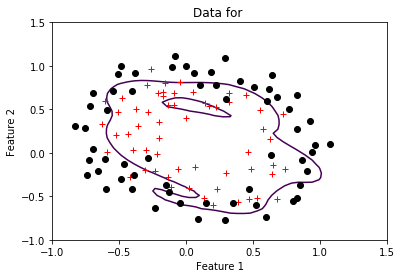

In [4]:
plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]	
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')

plotX1 = np.linspace(-1, 1.5, 50)
plotX2 = np.linspace(-1, 1.5, 50)
X, Y = np.meshgrid(plotX1, plotX2) 
Z = np.zeros((len(plotX1), len(plotX2)))
for i in np.arange(0,len(plotX1)):
    for j in np.arange(0, len(plotX2)):
        Z[i,j] = predict(theta, plotX1[i], plotX2[j])       # 计算每个点对应的预测结果
plt.contour(plotX1, plotX2, Z, levels=[0])                  # 仅绘制Z=0的等值线

plt.show()

上述边界线对于训练数据的分类结果是比较好的，但红色点中心区部分也出现了一个边界区域，这意味着区域内的数据点将被分到另一个类别中，而这是不合理的(中心区部分所有数据点都应该是同一个类别的)。这实际上造成了过拟合。

### **案例2：引入Regulization机制**
> 
* 核心思想：即使因为特征维度数量很多造成权重参数也很多，也要尽可能使每个权重参数的值尽可能的小
* 修改成本函数如下:  
$ J(\theta)= \dfrac{1}{m} \sum_{i=1}^m [-y^{(i)} log(h_\theta(x^{(i)}))-(1-y^{(i)}) log(1-h_\theta(x^{(i)}))] + \dfrac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $  
 * 成本函数中加入了$\theta^2$项(这一项也可称为penalty项)，这就使得每一个$\theta$不能太大，从而在一定程度上防止了过拟合。
 * $\lambda$用于调整$\theta$的权重，如果$\lambda$很大，则$\theta$被迫非常小，从而防止过拟合，但有可能造成欠拟合；如果$\lambda$太小，则过拟合的可能性会大大增加；如果$\lambda=0$，则与之前未采用Regulization方法时完全相同
 * 请注意：$\theta_0$(Intercept Item)不参与penalty项的计算
* 修改BGD梯度计算如下：  
$ \theta_j=\theta_j - \alpha(\dfrac{\partial J(\theta)}{\partial \theta_j}) $  
$ \dfrac{\partial J(\theta)}{\theta_j} = \dfrac{1}{m} \sum_{i=1}^m [(h_\theta (x^{(i)}) - y^{(i)}) x_j^{(i)}] + \dfrac{\lambda}{m} \theta_j $  
 * 上面的式子适用于$\theta_1$及以上的权重参数(也就是除了$\theta_0$以外的权重)迭代计算。
 * 对于$\theta_0$，仍与未采用Regulization方法时的梯度计算公式相同
* 在下面的代码中，可尝试调整LAMBDA的值，观察不同$\lambda$对最终权重参数计算结果的影响

Optimization terminated successfully.
         Current function value: 0.394594
         Iterations: 95
         Function evaluations: 96
         Gradient evaluations: 96
[ 2.75400815  1.80619105  2.95794616 -4.21521413 -3.38165717 -4.22521931
  0.74750046 -1.07864317 -0.47319524 -0.50175409 -3.26593586  0.53070882
 -1.76829851 -1.20672636 -2.77828978 -0.62175015 -0.47210117  0.62451533
 -1.13455543 -1.20540241 -0.09267019 -2.62899698  0.4513445  -0.7337415
  0.42253803 -1.14618836 -0.96098688 -1.14619991]
[-23.8549364  -22.07765151 -20.51156739 -19.12903521 -17.90573931
 -16.82041219 -15.85456417 -14.99222754 -14.21971531 -13.52539448
 -12.89947391 -12.33380667 -11.82170706 -11.35778206 -10.93777747
 -10.55843846 -10.2173848   -9.91300061  -9.64433861  -9.41103899
  -9.21326286  -9.05164013  -8.92723214  -8.84150861  -8.79633941
  -8.79400064  -8.83719543  -8.92908924  -9.07335972  -9.27426112
  -9.53670325  -9.86634505 -10.26970263 -10.75427196 -11.328666
 -12.00276655 -12.78789047 

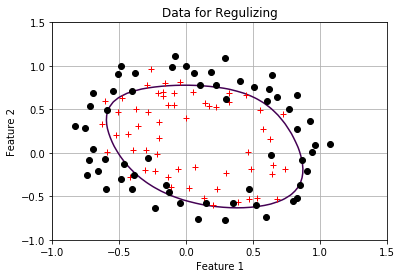

In [5]:
''' 观察不同的Regularization权重对Overfit的影响 '''

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

def mapFeatures(x1, x2):            # 生成6阶双变量的多项式拟合特征值矩阵
    rowCount = len(x1)
    colIndex = 1                    # 第0列为Intercept Item，无需进行计算
    features = np.ones((rowCount, FEATURE_COUNT))
    for i in np.arange(1, DEGREE+1):        # 1,2,3....DEGREE
        for j in np.arange(0, i+1):         # 0,1,2...i
            features[:,colIndex] = (x1 ** (i-j))*(x2 ** j)      # 每个循环计算1列Feature
            colIndex = colIndex + 1
    return features

def predict(theta, a, b):           # 根据6阶双变量的多项式拟合系数，计算当特征值为(a,b)时的预测结果
    result = theta[0]               # 先合计Intercept Item
    index = 1
    for i in np.arange(1, DEGREE+1):
        for j in np.arange(0, i+1):
            result = result + theta[index]*(a ** (i-j))*(b ** j)
            index = index + 1
    return result


# 定义全局变量
trainData = np.loadtxt(open('data_for_regulizing.csv', 'r'), delimiter=",",skiprows=0)
LAMBDA = 0.1                # 调整lambda的大小(例如0,,0.001,0.01,0.1,1,10)，可以看到不同的拟合曲线
DEGREE = 6                  # 最高为6阶
FEATURE_COUNT = 28          # 两个变量，6阶公式，共28个Feature(含Intercept Item)
ROW_COUNT = len(trainData)  # 总行数
x1 = trainData[:,0]         # 第一个变量
x2 = trainData[:,1]         # 第二个变量
y = trainData[:,2]          # 因变量

features = mapFeatures(x1, x2)      # 获得一个ROW_COUNT x FEATURE_COUNT维度的特征值数组

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

# Cost Function以theta为参数
def costFn(theta):
    temp = sigmoid(features.dot(theta))
    origin = (-y.dot(np.log(temp)) - (1-y).dot(np.log(1-temp))) / ROW_COUNT     # 未加Regulization时的cost
    penalty = LAMBDA * np.sum(theta[1:] ** 2) / (2*ROW_COUNT)                   # 加入Regulization后的penalty
    return origin + penalty         # Intercept Item项不列入penalty计算

# Gradient Function以theta为参数
def gradientFn(theta):
    originGradient = features.T.dot(sigmoid(features.dot(theta)) - y) / ROW_COUNT   # 未加Regulization时的gradient
    penaltyGradient = np.hstack((np.array([0]), LAMBDA * theta[1:])) / ROW_COUNT    # 加入Regulization后的gradient
    return originGradient + penaltyGradient         # Intercept Item项不列入penaltyGradient计算

np.random.seed(0)
init_theta = np.random.random(FEATURE_COUNT)      # 随机初始化theta
result = opt.minimize(costFn, init_theta, method='BFGS', jac=gradientFn, options={'disp': True})
theta = result.x
print(theta)

def initPlot():
    plt.figure()
    plt.title('Data for Regulizing')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    return plt

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]	
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')

# 准备绘制边界曲线的点集
plotX1 = np.linspace(-1, 1.5, 50)
plotX2 = np.linspace(-1, 1.5, 50)
Z = np.zeros((len(plotX1), len(plotX2)))
for i in np.arange(0,len(plotX1)):
    for j in np.arange(0, len(plotX2)):
        Z[i,j] = predict(theta, plotX1[i], plotX2[j])           # 计算每个点对应的预测结果
print(Z[0])
plt.contour(plotX1, plotX2, Z, levels=[0])                      # 仅绘制Z=0的等值线

plt.show()

> 观察不同$\lambda$对结果的影响  
* $\lambda=10$  
![](../images/080201.png)  
* $\lambda=0.1$  
![](../images/080202.png)  
* $\lambda=0.001$  
![](../images/080203.png)  
* 可见，$\lambda$越大，overfit可能性越小，但underfit的可能性增加；$\lambda$越小，overfit可能性增加，但underfit可能性减小

### **案例3：LogisticRegression内置的正则化支持**
>  
* LogisticRegression本身已经考虑了Regulazation问题，因此在调用本对象进行拟合时，其overfit和underfit均控制得较好
* 在构造LogisticRegression对象时，可以传入penalty参数，即指定Regulazation方式。默认值L2就是采用权重平方和。而参数C就是$\dfrac{1}{\lambda}$
* 因为LogisiticRegression默认会自动追加Intercept Term，因此在*mapFeatures*函数中不返回第一列(Intercept Term列)
* *LogisticRegression.predict*将直接返回判别分类结果(0或1)，在做等值线图时，取Z=0.5作为决策边界

Intercept Term Theta: 2.7538468068513478
Other Theatas: [ 1.80688036  2.95625633 -4.21473559 -3.38027658 -4.22566831  0.74552319
 -1.0775004  -0.47133113 -0.49857514 -3.26545606  0.52810834 -1.76349853
 -1.20784351 -2.77776993 -0.62143455 -0.46957391  0.62394392 -1.13714057
 -1.21143309 -0.09123638 -2.63065664  0.44588586 -0.73623946  0.42649778
 -1.14916128 -0.95758423 -1.14913843]


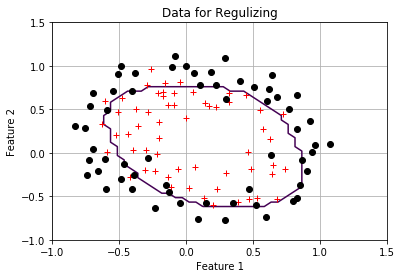

In [6]:
''' 观察LogisticRegression如何自行处理Overfit '''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def mapFeatures(x1, x2):            # 生成6阶双变量的多项式拟合特征值矩阵
    rowCount = len(x1)
    colIndex = 1                    # 第0列为Intercept Item，无需进行计算
    features = np.ones((rowCount, FEATURE_COUNT))
    for i in np.arange(1, DEGREE+1):        # 1,2,3....DEGREE
        for j in np.arange(0, i+1):         # 0,1,2...i
            features[:,colIndex] = (x1 ** (i-j))*(x2 ** j)      # 每个循环计算1列Feature
            colIndex = colIndex + 1
    return features[:, 1:]    # 第0列的Intercept不返回，因为LogisticRegression将会自动追加该列

trainData = np.loadtxt(open('data_for_regulizing.csv', 'r'), delimiter=",",skiprows=0)
DEGREE = 6                
FEATURE_COUNT = 28         
ROW_COUNT = len(trainData) 
x1 = trainData[:,0]         
x2 = trainData[:,1]       
xTrain = mapFeatures(x1, x2)
yTrain = trainData[:,2]

# C=10，相当于LAMBDA=0.1
model = LogisticRegression(solver='lbfgs', penalty='l2', C=10)   
model.fit(xTrain, yTrain)
print("Intercept Term Theta:", model.intercept_[0])
print("Other Theatas:", model.coef_[0])

def initPlot():
    plt.figure()
    plt.title('Data for Regulizing')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    return plt

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')

plotX1 = np.linspace(-1, 1.5, 50)
plotX2 = np.linspace(-1, 1.5, 50)
Z = np.zeros((len(plotX1), len(plotX2)))
for i in np.arange(0, len(plotX1)):                         # 每次预测一列点
    a1 = [plotX1[i] for _ in np.arange(0, len(plotX2))]
    plotFeatures = mapFeatures(a1, plotX2)
    Z[i,:] = model.predict(plotFeatures)
plt.contour(plotX1, plotX2, Z, levels=[0.5])    # 取Z=0.5作为决策边界

plt.show()